In [21]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("llama3-1.json","r") as file:
    llama_chat=json.load(file)

with open("gemma2.json","r") as file:
    gemma2_chat=json.load(file)


true_data=pd.read_csv("QAv2.csv",header=1)
true_data['expected_role']=true_data["Expected Role"]
objectives=list(true_data['Objective'].values)
expected_roles=list(true_data['expected_role'].values)

In [15]:
print(len(llama_chat),len(gemma2_chat),len(expected_roles))

115 115 115


## First we will carry out analysis of classified roles

Accuracy of llama3.1 on role classification: 86.95652173913044 %
Accuracy of gemma2 on role classification: 87.82608695652175 %


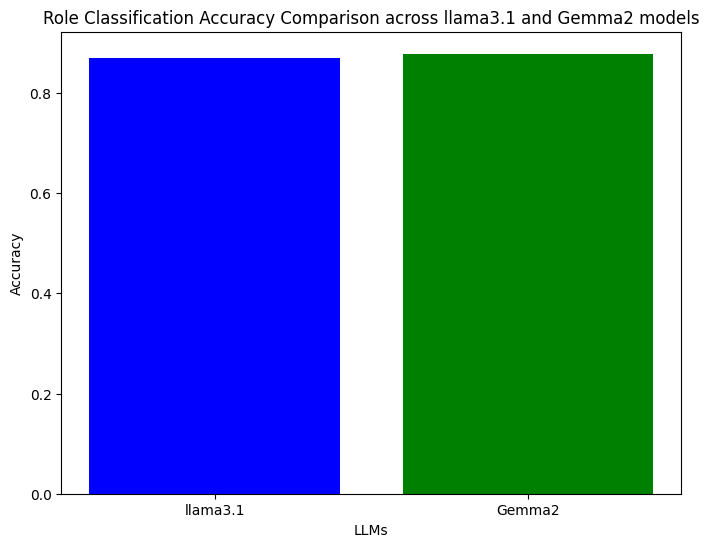

In [22]:
tracker_l,tracker_g=[],[]
obj_l,obj_g=[],[]
for llama,gemma,true,obj in zip(llama_chat,gemma2_chat,expected_roles,objectives): 
    tracker_l.append(1) if llama['role'] in true else tracker_l.append(0)
    obj_l.append(1) if llama['role'] in true else obj_l.append(0)

    tracker_g.append(1) if gemma['role'] in true else tracker_g.append(0)
    obj_g.append(1) if gemma['role'] in true else obj_g.append(0)


# now we are going to calcuate accuracy:
accuracy_l=sum(tracker_l)/len(tracker_l)
accuracy_g=sum(tracker_g)/len(tracker_g)

print("Accuracy of llama3.1 on role classification:", accuracy_l*100,"%")
print("Accuracy of gemma2 on role classification:", accuracy_g*100,"%")
# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['llama3.1', 'Gemma2'], [accuracy_l, accuracy_g], color=['blue', 'green'])

# Adding title and labels
plt.title('Role Classification Accuracy Comparison across llama3.1 and Gemma2 models')
plt.xlabel("LLMs")
plt.ylabel('Accuracy')

# Display plot
plt.show()


In [4]:
# Next step is to identify correct classification of each objective

In [23]:
corr_obj_l,corr_obj_g=[],[]
neg_obj_l,neg_obj_g=[],[]
objectives = ["Syllabus" if isinstance(obj, float) else obj for obj in objectives]
for true_o,llama_o,gemma_o in zip(objectives,obj_l,obj_g):
    if llama_o==1:
        corr_obj_l.append(true_o)
    else:
        neg_obj_l.append(true_o)
        
    if gemma_o==1:
        corr_obj_g.append(true_o)
    else:
        neg_obj_g.append(true_o)
    
corr_obj_l = [x for x in corr_obj_l if not isinstance(x, float)]
corr_obj_g = [x for x in corr_obj_g if not isinstance(x, float)]


Gemma2-accuracies [20.0, 100.0, 92.3076923076923, 92.5925925925926, 100.0, 100.0, 92.3076923076923, 85.71428571428571]
Llama3.1-accuracies [20.0, 100.0, 92.3076923076923, 88.88888888888889, 100.0, 100.0, 92.3076923076923, 85.71428571428571]
Labels ['Follow Up question', 'Syllabus', 'with homework hint', 'with homework hint and homework index', 'with lecture hint', 'with lecture hint and lecture index', 'without homework hint', 'without lecture hint']


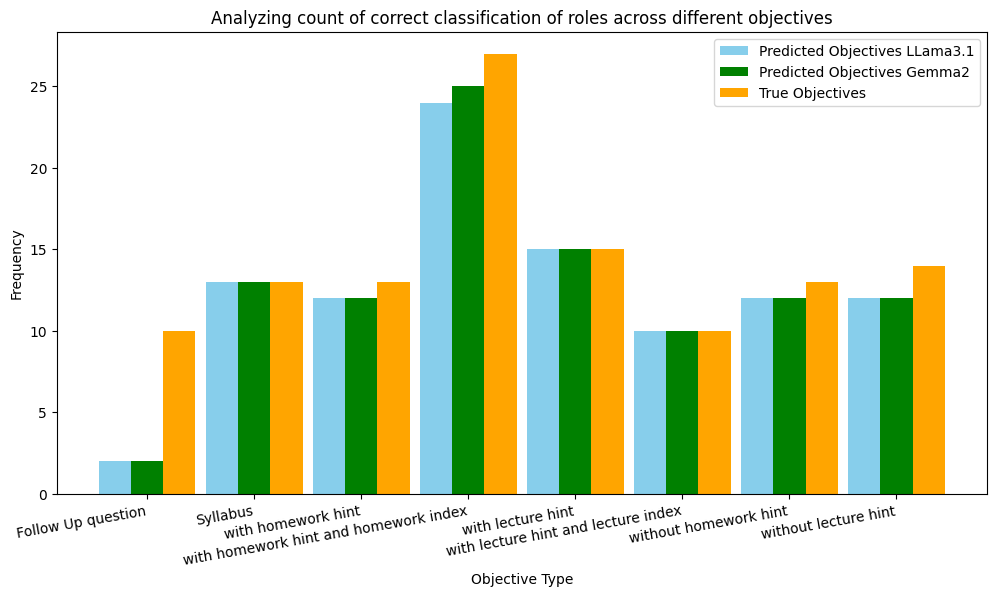

In [24]:
from collections import Counter
import numpy as np

# Count occurrences of each unique item in the list
counter = Counter(corr_obj_l)
counter_g=Counter(corr_obj_g)
true_counter=Counter(objectives)

# Get the union of all unique items from both lists
all_labels = sorted(set(counter.keys()).union(true_counter.keys()).union(counter_g.keys()))

# Extract values for both counts, using 0 for items that are not present in one of the lists
values = [counter.get(label, 0) for label in all_labels]
g_values=[counter_g.get(label, 0) for label in all_labels]
true_values = [true_counter.get(label, 0) for label in all_labels]
g_accuracies=[(i/j)*100 for i,j in zip(g_values,true_values)]
l_accuracies=[(i/j)*100 for i,j in zip(values,true_values)]
print("Gemma2-accuracies",g_accuracies)
print("Llama3.1-accuracies",l_accuracies)
print("Labels",all_labels)


# Set the positions and width for the bars
x = np.arange(len(all_labels))  # label locations
width = 0.35  # width of the bars

# Create the plot
plt.figure(figsize=(12, 6))
width=0.3
# Plot llama results
plt.bar(x - width, values, width, label='Predicted Objectives LLama3.1', color='skyblue')
plt.bar(x , g_values, width, label='Predicted Objectives Gemma2', color='green')

# Plot true objectives
plt.bar(x + width, true_values, width, label='True Objectives', color='orange')

# Add labels and title
plt.xlabel('Objective Type')
plt.ylabel('Frequency')
plt.title('Analyzing count of correct classification of roles across different objectives')
plt.xticks(x, all_labels, rotation=10, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
# plt.savefig("Figures/correct_classification_across_objectives.png")

## LLM based evaluation Metrics

In [81]:
# !pip install nltk rouge-score bert-score

In [82]:
# pip install rouge

In [83]:
# Evaluation of Lecture related questions


# LLM evaluation of Questions with expected answer {lecture and syllabus related questions}

In [25]:
column_to_filter = 'Objectives'  
specific_values = ['with lecture hint', 'with lecture hint and lecture index','without lecture hint',
                'Syllabus'] 
true_data["Objectives"] = true_data["Objective"].fillna("Syllabus")
# Filter the DataFrame
filtered_ls = true_data[true_data[column_to_filter].isin(specific_values)].reset_index()
specific_values.append("Follow Up question")
filtered_h=true_data[~true_data[column_to_filter].isin(specific_values)].reset_index()

# now let us gather chat response based on llama and gemma2 for corresponding filters
indexes=list(filtered_ls['index'].values)
llama_QA=[i['response'] for enum,i in enumerate(llama_chat) if enum in indexes ]
gemma2_QA=[i['response'] for enum,i in enumerate(gemma2_chat) if enum in indexes ]
solution_QA=list(filtered_ls['Expected Solution'].values)  # contains expected solutoin of given question
Question=list(filtered_h['Actual Question'].values)  # contains actual question in the homework file
print(len(llama_QA),len(gemma2_QA),len(solution_QA),len(Question),len(filtered_h))

52 52 52 53 53


In [6]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from bert_score import score as bert_score

# Initialize ROUGE
rouge = Rouge()

def calculate_bleu(predictions, references):
    bleu_scores = []
    for pred, refs in zip(predictions, references):
        score = sentence_bleu(refs, pred.split())
        bleu_scores.append(score)
    return bleu_scores

def calculate_rouge(predictions, references):
    rouge_scores = []
    for pred, refs in zip(predictions, references):
        scores = rouge.get_scores(pred, refs)  # Taking the first reference for simplicity
        rouge_scores.append(scores[0])  # Append the first score
    return rouge_scores

def calculate_bertscore(predictions, references):
    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    return P, R, F1



def llm_lecture_metric(setup,mode):

    # Initialize dictionaries to hold the metric values
    bleu_scores = {}
    rouge_scores = {'rouge1': {}, 'rouge2': {}, 'rougeL': {}, 'rougeLsum': {}}
    bert_scores = {'precision': {}, 'recall': {}, 'f1': {}}
    for key, values in setup.items():
        # Calculate BLEU scores
        print(f"============================The metrics for {key} are============================")
        results = bleu.compute(predictions=values, references=solution_QA)
        bleu_scores[key] = results['bleu']
        print(f'BLEU Scores {key}: {results["bleu"]}')
        
        # Calculate ROUGE scores
        results = rouge.compute(predictions=values, references=solution_QA)
        rouge_scores['rouge1'][key] = results['rouge1']
        rouge_scores['rouge2'][key] = results['rouge2']
        rouge_scores['rougeL'][key] = results['rougeL']
        rouge_scores['rougeLsum'][key] = results['rougeLsum']
        print(f'ROUGE Scores {key}: {results}')
        
        # Calculate BERTScore
        result = bertscore.compute(predictions=values, references=solution_QA, lang="en")
        bert_scores['precision'][key] = np.mean(result['precision'])
        bert_scores['recall'][key] = np.mean(result['recall'])
        bert_scores['f1'][key] = np.mean(result['f1'])
        print(f'Bert Precision: {key}, {np.mean(result["precision"])}')
        print(f'Bert Recall: {key}, {np.mean(result["recall"])}')
        print(f'Bert F1: {key}, {np.mean(result["f1"])}')
    
    # Plotting the scores
    keys = list(setup.keys())
    
    # Plot BLEU scores
    plt.figure(figsize=(12, 10))
    plt.suptitle(f"Various LLM based evaluation metric across {mode}")
    plt.subplot(4, 1, 1)
    plt.bar(keys, [bleu_scores[key] for key in keys], color='skyblue')
    plt.title('BLEU Scores')
    plt.ylabel('Score')
    
    # Plot ROUGE Scores: rouge1, rouge2, rougeL, rougeLsum
    plt.subplot(4, 1, 2)
    plt.bar(keys, [rouge_scores['rouge1'][key] for key in keys], color='lightgreen', label='ROUGE-1')
    plt.bar(keys, [rouge_scores['rouge2'][key] for key in keys], color='lightcoral', label='ROUGE-2', alpha=0.7)
    plt.bar(keys, [rouge_scores['rougeL'][key] for key in keys], color='lightblue', label='ROUGE-L', alpha=0.5)
    plt.bar(keys, [rouge_scores['rougeLsum'][key] for key in keys], color='yellowgreen', label='ROUGE-Lsum', alpha=0.4)
    plt.title('ROUGE Scores')
    plt.ylabel('Score')
    plt.legend()

    # Plot BERT F1 scores
    plt.subplot(4, 1, 3)
    plt.bar(keys, [bert_scores['f1'][key] for key in keys], color='salmon')
    plt.title('BERT F1 Scores')
    plt.ylabel('Score')
    
    plt.xlabel('Models')
    plt.tight_layout()
    # plt.savefig("Figures/llm_eval_metric_lecture_slides.png")
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The finding shows that gemma2 outperforms llama3.1 in all the cases.  However, bertscore might be the only evaluation metric for testing and detailed analysis of how the model is generating the result is also an important aspect as we want the assistant to answer the way instructor answers. Likewise, further analysis on diverse roles of the instructor is also necessary.

============================The metrics for llama3.1 are============================
BLEU Scores llama3.1: 0.08074291267233162
ROUGE Scores llama3.1: {'rouge1': 0.36892455937993957, 'rouge2': 0.17866755566585524, 'rougeL': 0.2851467197641236, 'rougeLsum': 0.3034318230066535}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Precision: llama3.1, 0.8614739363010113
Bert Recall: llama3.1, 0.8556525627007852
Bert F1: llama3.1, 0.8581069730795347
============================The metrics for gemma2 are============================
BLEU Scores gemma2: 0.11505836798614279
ROUGE Scores gemma2: {'rouge1': 0.4623117598284875, 'rouge2': 0.2766846713082286, 'rougeL': 0.3712548016937377, 'rougeLsum': 0.3867233633979993}
Bert Precision: gemma2, 0.8733203021379617
Bert Recall: gemma2, 0.8725381585267874
Bert F1: gemma2, 0.8721838604945403


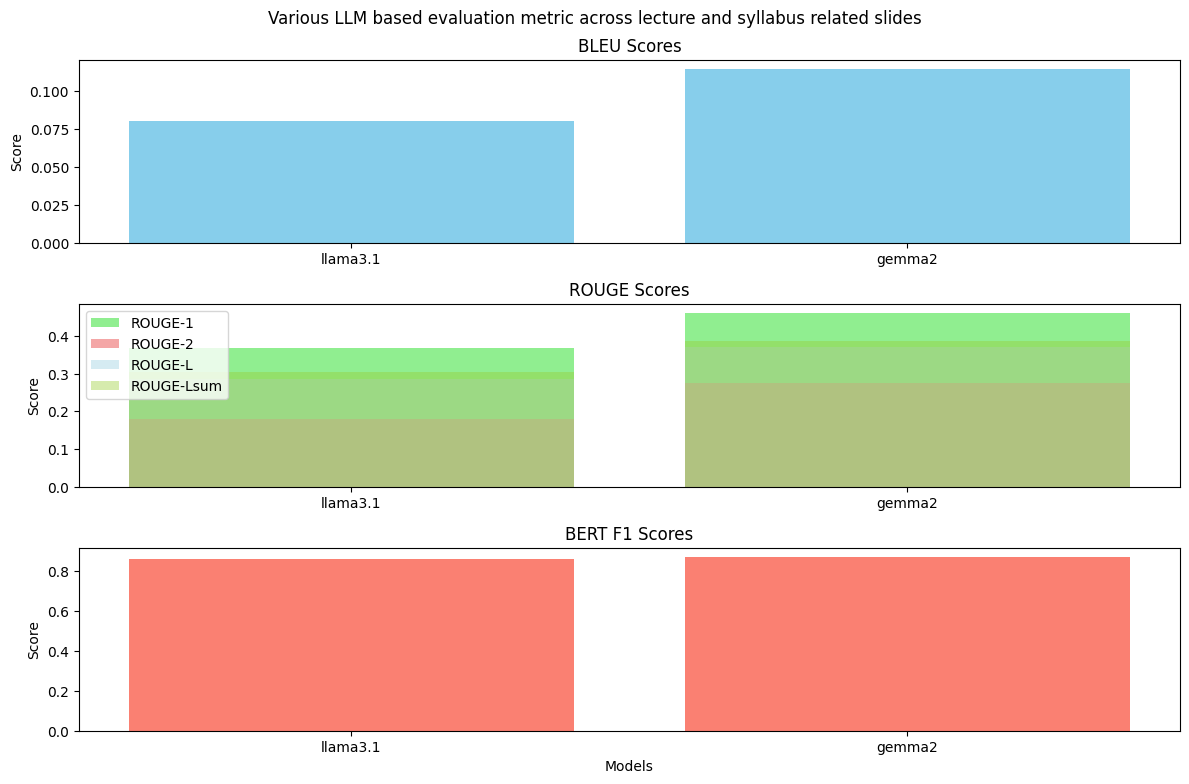

In [8]:
from evaluate import load
bertscore = load("bertscore")
bleu = load("bleu")
rouge=load('rouge')
setup={"llama3.1":llama_QA,"gemma2":gemma2_QA}
llm_lecture_metric(setup,mode="lecture and syllabus related slides")


## LLM prompt based evaluation for lecture and syllabus related slides


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.llms import Ollama

def generate_output(prompt,setup,solution_QA):    
    llm1=Ollama(model="llama3.1")
    llm2=Ollama(model="gemma2")   
    llm_eval={"llama3.1":[],"gemma2":[]}
    count=0
    for llama,gemma,true in zip(setup['llama3.1'],setup['gemma2'],solution_QA):
        count=count+1
        print(count)
        llama_prompt=f"""
        ## True Paragraph: {true}
    
        ## Predicted Paragraph: {llama}
    
        ## Output:
        """
        output=llm1(prompt+llama_prompt)
        llm_eval['llama3.1'].append(output)
    
        gemma_prompt=f"""
        ## True Paragraph: {true}
    
        ## Predicted Paragraph: {gemma}
    
        ## Output:
        """
    
        output=llm2(prompt+gemma_prompt)
        llm_eval['gemma2'].append(output)
    return llm_eval
        

In [12]:
prompt_lecture=f"""
    You are a faithful and respectful assistant whose role is that of a evaluator. You will be given a true paragraph and a predicted paragraph and based on the information given,
    give a number result from the list [0,1,2,3,4] based on the relevancy of predicted paragraph with the true paragraph.
    The definition of each code is given below:
    0: Not Relevant: The predicted paragraph does not relate to the true paragraph in any meaningful way. The content, context, or subject matter is completely different.
    1: Slightly Relevant: The predicted paragraph has some connection to the true paragraph, but the relevance is minimal. There may be a few overlapping ideas or themes, but they are not clearly aligned.
    2: Moderately Relevant: The predicted paragraph shows a fair level of relevance to the true paragraph. It addresses some of the same topics or ideas but may not cover all aspects or may diverge in some significant way.
    3: Highly Relevant: The predicted paragraph is closely related to the true paragraph. It reflects the main ideas or themes accurately and addresses the majority of the points discussed in the true paragraph.
    4: Perfectly Relevant: The predicted paragraph is entirely relevant to the true paragraph. It aligns perfectly with the content, context, and subject matter, reflecting all the key points accurately.
    Note: Your answer should striclty based on one rating from 0 to 4.
    
    """
llm_eval=generate_output(prompt_lecture,setup,solution_QA)


1


/var/folders/hk/rt1vv1js1rv6pltm70r0s66w0000gn/T/ipykernel_1293/3418128682.py:21: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  output=llm1(prompt+llama_prompt)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


NameError: name 'data' is not defined

In [44]:
filtered_llm_eval={"llama3.1":[],"gemma2":[]}
scores={0:"Not Relevant",1:"Slightly Relevant",2:"Moderately Relevant",3:"Highly Relevant",4:"Perfectly Relevant"}
 
for key,value in llm_eval.items():
    
    for each_value in value:
        if str(0) in each_value or "not relevant" in each_value.lower():
            filtered_llm_eval[key].append(0)
        elif str(1) in each_value or "slightly relevant" in each_value.lower():
            filtered_llm_eval[key].append(1)
        elif str(2) in each_value or "moderately relevant" in each_value.lower():
            filtered_llm_eval[key].append(2)            
        elif str(3) in each_value or "highly relevant" in each_value.lower():
            filtered_llm_eval[key].append(3)   
        elif str(4) in each_value or "perfectly relevant" in each_value.lower():
            filtered_llm_eval[key].append(4)  
        else:
            print(key,each_value)

            
with open('llm_lecture_eval_prompt.json', 'w') as json_file:
    json.dump(llm_eval,json_file,indent=4)

with open('llm_filtered_lecture_eval_prompt.json', 'w') as json_file:
    json.dump(filtered_llm_eval,json_file,indent=4)



In [26]:
import json
import numpy as np
scores={0:"Not Relevant",1:"Slightly Relevant",2:"Moderately Relevant",3:"Highly Relevant",4:"Perfectly Relevant"}
import matplotlib.pyplot as plt
with open('llm_filtered_lecture_eval_prompt.json', 'r') as json_file:
    filtered_llm_eval=json.load(json_file)

In [27]:
def plot_relevance_score_LLM(llm_eval,scores,mode):
    relevance_range = range(0,5)
    labels=list(scores.values())
    frequencies = {model: [llm_data.count(sc) for sc,mean in scores.items()] for model, llm_data in llm_eval.items()} 
    # Set up the plot
    plt.figure(figsize=(10, 6))    
    # Define the number of LLMs and set bar width and positions
    n_models = len(llm_eval)
    bar_width = 0.35
    index = np.arange(len(relevance_range))  # x locations for the groups    
    # Plot the bars for each LLM
    for i, (model, freq) in enumerate(frequencies.items()):
        plt.bar(index + i * bar_width, freq, bar_width, label=model)
    # Add labels and titles
    plt.xlabel('Relevance Score')
    plt.ylabel('Frequency')
    plt.title(f'Relevance Scores Frequency by llama3.1 LLM for {mode}')
    plt.xticks(index + bar_width / n_models, labels)  # Proper positioning of x-ticks
    plt.legend()   
    # Display the plot
    plt.tight_layout()
    # plt.savefig(f"Figures/Relevance_score_{mode}.png")
    plt.show()

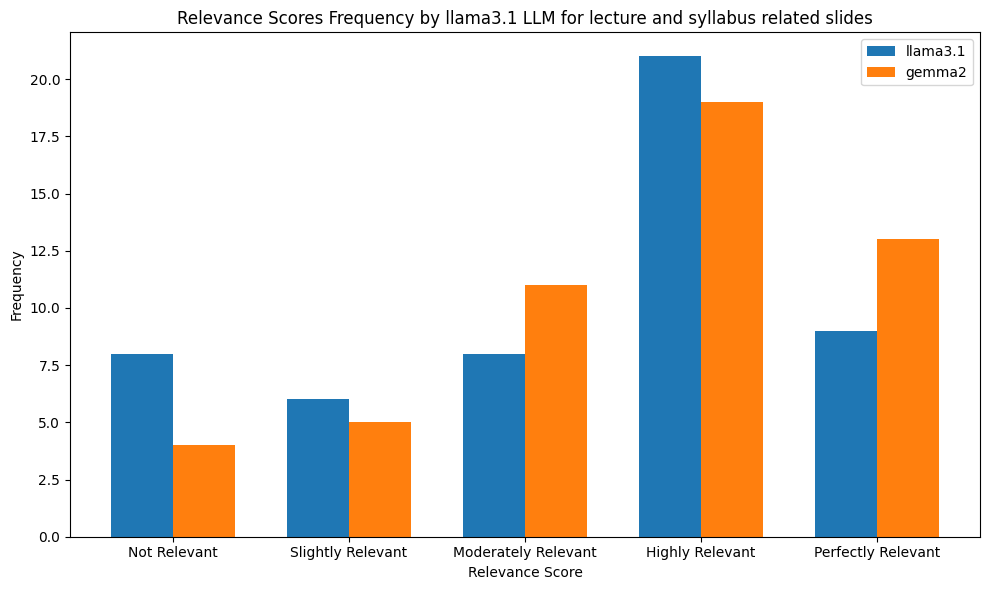

In [28]:
plot_relevance_score_LLM(filtered_llm_eval,scores,mode="lecture and syllabus related slides")

Now, I want to plot relevancy scores across different modalities of LLM: we aim to understand how the LLM evaluates relevancy given the condition in the lecture slide across different input methods like without hint of lecture, with hint of lecture, with hint of lecture along with lecture index

In [29]:
def distribution_list(relevancy_scores):
    distribution = Counter(relevancy_scores)
            
    # Calculate the total number of scores
    total_scores = len(relevancy_scores)
    
    # Calculate the percentage distribution
    percentage_distribution = {key: (value / total_scores) * 100 for key, value in distribution.items()}
    return percentage_distribution

Objectives without lecture hint
llama {'Not Relevant': 14.285714285714285, 'Slightly Relevant': 7.142857142857142, 'Moderately Relevant': 14.285714285714285, 'Highly Relevant': 50.0, 'Perfectly Relevant': 14.285714285714285}
gemma {'Not Relevant': 7.142857142857142, 'Slightly Relevant': 21.428571428571427, 'Moderately Relevant': 21.428571428571427, 'Highly Relevant': 42.857142857142854, 'Perfectly Relevant': 7.142857142857142}
Objectives with lecture hint
llama {'Not Relevant': 13.333333333333334, 'Slightly Relevant': 6.666666666666667, 'Moderately Relevant': 6.666666666666667, 'Highly Relevant': 53.333333333333336, 'Perfectly Relevant': 20.0}
gemma {'Not Relevant': 6.666666666666667, 'Slightly Relevant': 13.333333333333334, 'Moderately Relevant': 33.33333333333333, 'Highly Relevant': 40.0, 'Perfectly Relevant': 6.666666666666667}
Objectives with lecture hint and lecture index
llama {'Not Relevant': 10.0, 'Slightly Relevant': 20.0, 'Moderately Relevant': 30.0, 'Highly Relevant': 20.0, 

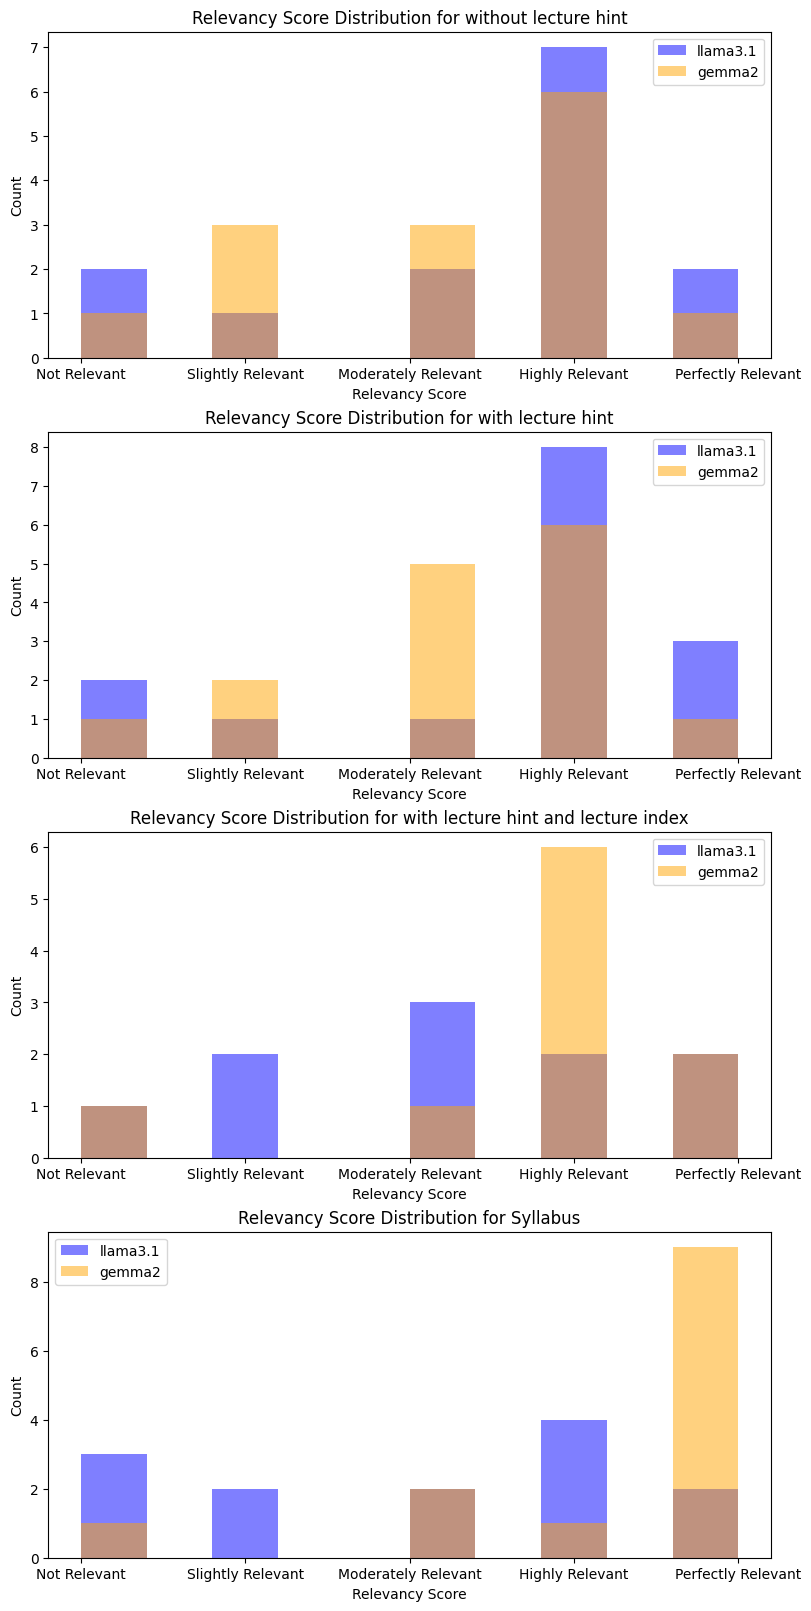

In [30]:
def plot_obj_relevancy_score(objective_QA, llm_eval,scores, mode):
    # Initialize a dictionary to store scores for each model
    objective_scores = {"llama3.1": {}, "gemma2": {}}
    
    # Populate the dictionary: map each objective to its list of scores
    for objective, llama_score, gemma_score in zip(objective_QA, llm_eval['llama3.1'], llm_eval['gemma2']):
        if objective not in objective_scores["llama3.1"]:
            objective_scores["llama3.1"][objective] = [llama_score]
            objective_scores["gemma2"][objective] = [gemma_score]
        else:
            objective_scores["llama3.1"][objective].append(llama_score)
            objective_scores["gemma2"][objective].append(gemma_score)
    
    # Number of unique objectives
    objectives = list(objective_scores['llama3.1'].keys())
    num_objectives = len(objectives)
    
    # Create subplots based on number of objectives
    fig, axes = plt.subplots(nrows=num_objectives, figsize=(8, num_objectives * 4), constrained_layout=True)
    
    if num_objectives == 1:
        axes = [axes]
    
    # Plot the data for each objective as a histogram
    for i, objective in enumerate(objectives):
        ax = axes[i]
        llama_s=objective_scores['llama3.1'][objective]
        llama_s=sorted(llama_s)
        llama_s=[scores[i] for i in llama_s]
        gemma_s=objective_scores['gemma2'][objective]
        gemma_s=sorted(gemma_s)
        gemma_s=[scores[i] for i in gemma_s]
        # Calculate the distribution
        
        print("Objectives",objective)
        print("llama",distribution_list(llama_s))
        print("gemma",distribution_list(gemma_s))
        
        # Plot histograms for both models on the same axes
        ax.hist(llama_s, bins=10, alpha=0.5, label='llama3.1', color='blue')
        ax.hist(gemma_s, bins=10, alpha=0.5, label='gemma2', color='orange')

        # Set labels and title
        ax.set_title(f"Relevancy Score Distribution for {objective}")
        ax.set_xlabel('Relevancy Score')
        ax.set_ylabel('Count')
        ax.legend()
    # plt.savefig(f"Figures/relevance_score_objectives_{mode}.png")
    plt.show()

scores={0:"Not Relevant",1:"Slightly Relevant",2:"Moderately Relevant",3:"Highly Relevant",4:"Perfectly Relevant"}
objective_QA=list(filtered_ls['Objective'].values)
objective_QA = ["Syllabus" if isinstance(obj, float) else obj for obj in objective_QA]
plot_obj_relevancy_score(objective_QA,filtered_llm_eval,scores,mode="lecture and syllabus related slides")

## LLM prompt based evaluation on Homework based queries

In [23]:
from prompt_template import GuidanceTemplate,HWClarificaitonTemplate

# now let us gather chat response based on llama and gemma2 for corresponding filters
indexes=list(filtered_h['index'].values)
llama_hw=[i['response'] for enum,i in enumerate(llama_chat) if enum in indexes ]
gemma2_hw=[i['response'] for enum,i in enumerate(gemma2_chat) if enum in indexes ]
Question=list(filtered_h['Actual Question'].values)  # contains actual question in the homework file
print(len(llama_hw),len(gemma2_hw),len(Question),len(filtered_h))
setup_hw={"llama3.1":llama_hw,"gemma2":gemma2_hw}
# llm_hw_metric(setup_homework,mode="Homework Question and Clarification related slides")
objective_hw=list(filtered_h['Objective'].values)
true_role_hw=list(filtered_h['Expected Role'].values)


def generate_hw_output(prompt,setup,solution_QA,expected_role):   
    llm1=Ollama(model="llama3.1")
    llm2=Ollama(model="gemma2")   
    llm_eval={"llama3.1":[],"gemma2":[]}
    twice=0
    for llama,gemma,question,e_role in zip(setup['llama3.1'],setup['gemma2'],solution_QA,expected_role):
        if "Providing Homework Guidance" and "Homework Question Clarification" in e_role:
            twice=True       
        elif "Homework Question Clarification" in expected_role:
            input_prompt=prompt[1]
            twice=False
        elif "Providing Homework Guidance" in e_role:
            twice=False
            input_prompt=prompt[1]
            
        llama_prompt=f"""
        ## Question: {question}
    
        ## Predicted Answer: {llama}
    
        ## Output:
        """
        if twice:
            output1=llm1(prompt[0]+llama_prompt)
            output2=llm1(prompt[1]+llama_prompt)
            llm_eval['llama3.1'].append((output1,output2))
        else:
            output=llm1(input_prompt+llama_prompt)
            llm_eval['llama3.1'].append(output)
    
        gemma_prompt=f"""
        ## Question: {true}
    
        ## Predicted Answer: {gemma}
    
        ## Output:
        """
        if twice:
            output1=llm2(prompt[0]+gemma_prompt)
            output2=llm2(prompt[1]+gemma_prompt)
            llm_eval['gemma2'].append((output1,output2))
        else:
            output=llm2(input_prompt+gemma_prompt)
            llm_eval['gemma2'].append(output)
    return llm_eval
    
prompt_hw_guidance=f"""
    You are a faithful and respectful assistant whose role is that of a evaluator. You will be given an actual question and a guidance answer and based on the information given,
    give a number result from the list [0,1,2,3,4] based on the guidance framework the answer is in.
    Note: You will be given an evaluation framework and based on that you need to answer:
    Guidance Framework:  List based suggestions, Example-based instruction, Metacognitive questioning, and problem-solving-then-refinement approach. Make sure the answer only give one type of guidance form at a time. Don't give the point answer.
    The definition of each code is given below:
    0: Not Relevant: The guidance answer is not related to the given question.
    1: Slightly Relevant: The guidance answer is related to the given question but gives direct answer to the question.
    2: Moderately Relevant: The guidance answer is related to the given question but gives indirect but correct answer to the question.
    3: Highly Relevant: The guidance answer is related to the given question, doesnot give exact direct solution but gives confusing answer.
    4: Perfectly Relevant: The guidance answer exactly follows one of the guidance approach and does not give the exact direct solution.
    Note: Your answer should striclty based on one rating from 0 to 4.  
    """

prompt_hw_clarification=f"""
    You are a faithful and respectful assistant whose role is that of a evaluator. You will be given an actual question and a clarification answer and based on the information given,
    give a number result from the list [0,1,2,3,4] based on the relevancy of predicted answer with the Actual Question.
    Note: You will be given an evaluation framework and based on that you need to answer:
    Clarification Framework: The predicted answer is not supposed to give direct answer, rather it should make student understand what the question is asking based on the question given to them. 
    The definition of each code is given below:
    0: Not Relevant: The clarification answer is not related to the given question.
    1: Slightly Relevant: The clarification answer is related to the given question but doesnot clarify the question.
    2: Moderately Relevant: The clarification answer is related to the given question, clarifies the question but gives indirect and correct answer to the question problem.
    3: Highly Relevant: The clarification answer is related to the given question, clarifies the question and doesnot give correct answer to the question problem. 
    4: Perfectly Relevant: The predicted answer exactly follows clarification framework and does not give the exact direct solution.
    Note: Your answer should striclty based on one rating from 0 to 4.  
    """
llm_hw_eval=generate_hw_output([prompt_hw_guidance,prompt_hw_clarification],setup_hw,solution_QA,true_role_hw)


53 53 53 53


In [115]:
with open('llm_hw_eval_prompt.json', 'w') as json_file:
    json.dump(llm_hw_eval,json_file,indent=4)

In [122]:
filtered_llm_hw_eval={"llama3.1":[],"gemma2":[]}
scores={0:"Not Relevant",1:"Slightly Relevant",2:"Moderately Relevant",3:"Highly Relevant",4:"Perfectly Relevant"}
import re

for key,value in llm_hw_eval.items():
    for each_value in value:
        if isinstance(each_value, tuple):
            matches = re.findall(r'[0-4]', str(each_value))
            # Convert matches to a set to get unique numbers
            unique_numbers = set(matches)
            filtered_llm_hw_eval[key].append(int(max(unique_numbers)))         
        elif str(0) in each_value or "not relevant" in each_value.lower():
            filtered_llm_hw_eval[key].append(0)
        elif str(1) in each_value or "slightly relevant" in each_value.lower():
            filtered_llm_hw_eval[key].append(1)
        elif str(2) in each_value or "moderately relevant" in each_value.lower():
            filtered_llm_hw_eval[key].append(2)            
        elif str(3) in each_value or "highly relevant" in each_value.lower():
            filtered_llm_hw_eval[key].append(3)   
        elif str(4) in each_value or "perfectly relevant" in each_value.lower():
            filtered_llm_hw_eval[key].append(4)  
        else:
            print(key,each_value)
with open('llm_filtered_hw_eval_prompt.json', 'w') as json_file:
    json.dump(filtered_llm_hw_eval,json_file,indent=4)

In [31]:
import json
import numpy as np
import matplotlib.pyplot as plt
with open('llm_filtered_hw_eval_prompt.json', 'r') as json_file:
    filtered_llm_hw_eval=json.load(json_file)

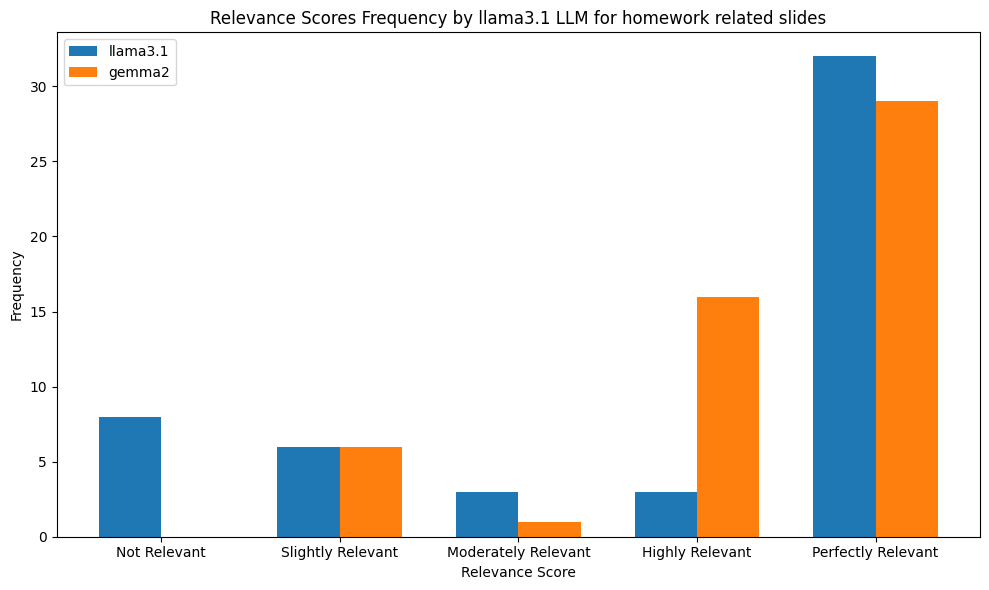

In [32]:
plot_relevance_score_LLM(filtered_llm_hw_eval,scores,mode="homework related slides")

In [41]:
def plot_relevance(llm_eval_lec,llm_eval_hw,scores,mode):
    plt.figure(figsize=(10, 6))    
    count=0
    for enum,llm_eval in enumerate([llm_eval_lec,llm_eval_hw]):
        relevance_range = range(0,5)
        labels=list(scores.values())
        frequencies = {model: [llm_data.count(sc) for sc,mean in scores.items()] for model, llm_data in llm_eval.items()} 
        # Set up the plot
        # Define the number of LLMs and set bar width and positions
        n_models = len(llm_eval)
        bar_width = 0.2
        index = np.arange(len(relevance_range))  # x locations for the groups    
        # Plot the bars for each LLM
        for model, freq in frequencies.items():
            plt.bar(index + count * bar_width, freq, bar_width, label=model+" Lecture/Syllabus" if enum==0 else model+" Homework")
            count=count+1
        bar_width=bar_width+0.2
    # Add labels and titles
    plt.xlabel('Relevance Score', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    # plt.title(f'Relevance Scores Frequency by llama3.1 LLM for {mode}', fontsize=20)
    plt.xticks(index + bar_width / n_models, labels, fontsize=18,rotation=10)  # Proper positioning of x-ticks
    plt.yticks(fontsize=18)
    plt.legend( fontsize=20)   
    # Display the plot
    plt.tight_layout()
    plt.savefig(f"Figures/Relevance_score.png")
    plt.show()

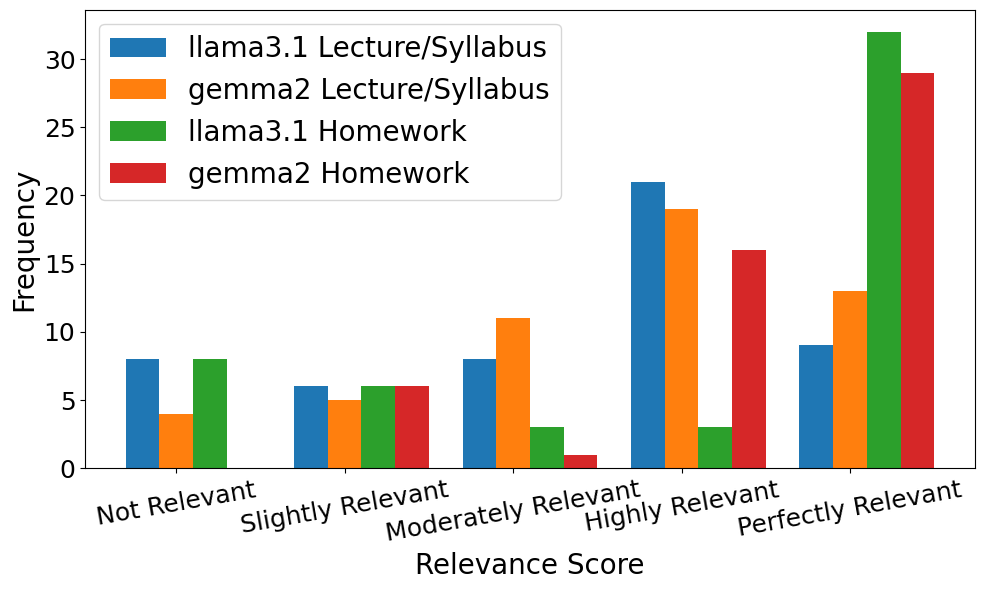

In [42]:
plot_relevance(filtered_llm_eval,filtered_llm_hw_eval,scores,mode="Lecture/Syllabus and Homework related queries")

In [17]:
plot_obj_relevancy_score(objective_hw,filtered_llm_hw_eval,scores,mode="homework related slides")

NameError: name 'objective_hw' is not defined

# analysis of incorrect role classification
## 1. lets start with followup question

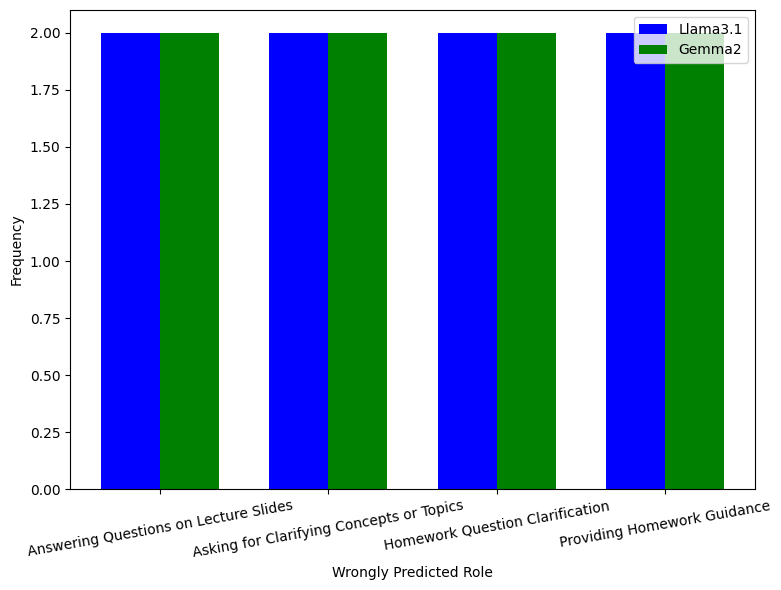

In [30]:
#before going deeper into follow up, lets see what role the model classifies the incorrectly classified roles


follow_up = true_data[true_data["Objective"].isin(["Follow Up question"])].reset_index()
# What are follow up questions, and what is it being classified into:
# now let us gather chat response based on llama and gemma2 for corresponding filters
follow_up_indexes=list(follow_up['index'].values)
llama_followup=[i['role'] for enum,i in enumerate(llama_chat) if enum in follow_up_indexes and i['role']!="Reply to previous conversation" ]
gemma_followup=[i['role'] for enum,i in enumerate(gemma2_chat) if enum in follow_up_indexes and i['role']!="Reply to previous conversation"]


# Count the frequency of each role in both LLMs
llama_counts = Counter(llama_followup)
gemma_counts = Counter(gemma_followup)
# Combine roles for a unified plot
all_roles = set(llama_counts.keys()).union(set(gemma_counts.keys()))

# Sort roles (optional, for consistent order in the plot)
sorted_roles = sorted(all_roles)

# Prepare data for plotting
llama_freq = [llama_counts[role] for role in sorted_roles]
gemma_freq = [gemma_counts[role] for role in sorted_roles]

# Plot the frequencies
plt.figure(figsize=(8, 6))
bar_width = 0.35
index = range(len(sorted_roles))

# Create the bar chart
plt.bar(index, llama_freq, bar_width, label='Llama3.1', color='blue')
plt.bar([i + bar_width for i in index], gemma_freq, bar_width, label='Gemma2', color='green')

# Add labels, title, and legend
plt.xlabel('Wrongly Predicted Role')
plt.ylabel('Frequency')
# plt.title('Distribution of Predicted Roles in Follow-Up Questions: Analyzing Misclassifications in Follow Up question Across Different LLMs')
plt.xticks([i + bar_width / 2 for i in index], sorted_roles,rotation=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig("Figures/followup-incorrect.png")
plt.show()
                                     

It looks like the followup question were incorrectly classified uniformly across all potential roles except syllabus 

## 1. lets start with followup question
with homework hint, without homework hint, without lecture hint: incorrect analysis:
lets categorize it as incorrect rest

In [164]:
#before going deeper into follow up, lets see what role the model classifies the incorrectly classified roles
incorrect_classification = true_data[true_data["Objective"].isin(["without homework hint","with homework hint","without lecture hint","with homework hint and homework index"])].reset_index()
objectives=list(incorrect_classification['Objective'].values)

indices=incorrect_classification['index']
incorrect_restl=[enum for enum,i in enumerate(obj_l) if enum in indices and i==0]  #incorrect roles index for llama3.1
incorrect_objl=[objectives[i] for i in incorrect_restl]  # objectives for llama3.1 with incorrectly classified role

incorrect_restg=[enum for enum,i in enumerate(obj_g) if enum in indices and i==0]  # incorred roles index for gemma2
incorrect_objg=[objectives[i] for i in incorrect_restg] #  objectives for gemma2 with incorrectly classified role

#keeping track of incorrect role predictions
incorrect_rest_pred_rolel,incorrect_rest_pred_roleg=[],[]
for enum,(llama,gemma) in enumerate(zip(llama_chat,gemma2_chat)):
    if enum in incorrect_restl:
        incorrect_rest_pred_rolel.append(llama['role'])
    if enum in incorrect_restg:
        incorrect_rest_pred_roleg.append(gemma['role'])
        
        
print(incorrect_rest_pred_rolel)     
print(incorrect_rest_pred_roleg)      
print(incorrect_restl)
print(incorrect_restg)
print(incorrect_objg)
print(incorrect_objl)
# This shows the same index is wrong

67
['Homework Question Clarification', 'Providing Homework Guidance', 'Providing Homework Guidance', 'Answering Questions on Lecture Slides']
['Homework Question Clarification', 'Providing Homework Guidance', 'Providing Homework Guidance', 'Answering Questions on Lecture Slides']
[6, 16, 39, 50]
[6, 16, 39, 50]
['without lecture hint', 'with homework hint and homework index', 'without homework hint', 'without homework hint']
['without lecture hint', 'with homework hint and homework index', 'without homework hint', 'without homework hint']


## Dump the document for human evaluation